In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path

In [2]:
data_dir = Path(r"C:\Users\neham\Downloads\Year 4\ProjectCodingFiles\Sem1_GAN\kerasGAN\Multi-Class_Classification\TrainingSet")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

60


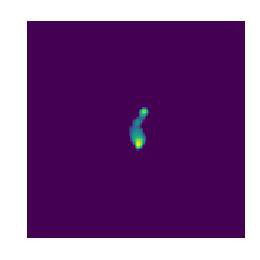

In [3]:
#generating a WAT pic
WAT = list(data_dir.glob('WATs/*'))
PIL.Image.open(str(WAT[13]))

In [4]:
#defining some parameters

batch_size = 64
img_height = 180
img_width = 180

#make a training set with 80-20 split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 17,
    image_size = (img_height,img_width),
    batch_size = batch_size)

Found 60 files belonging to 4 classes.
Using 48 files for training.


In [5]:
#make a validation set 
vals_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed = 17,
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 60 files belonging to 4 classes.
Using 12 files for validation.


['DoubleLobedStuff', 'MATs', 'NATs', 'WATs']


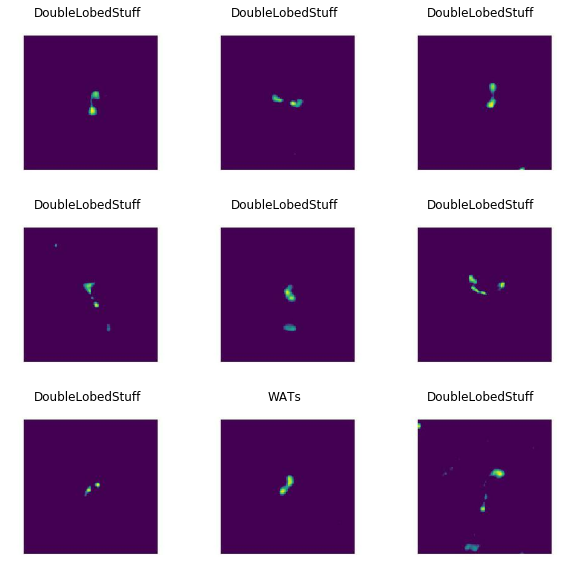

In [6]:
#verifying by printing class names
class_names = train_ds.class_names
print(class_names)

#visualising the data
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
#load data using dataset.cache() to prevent blocking I/O
#use Dataset.prefetch() to overlap data preprocessing and model execution

AUTOTUNE = tf.data.AUTOTUNE

train_df = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
vals_ds = vals_ds.cache().prefetch(buffer_size=AUTOTUNE)

#standardise/normalise the data

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


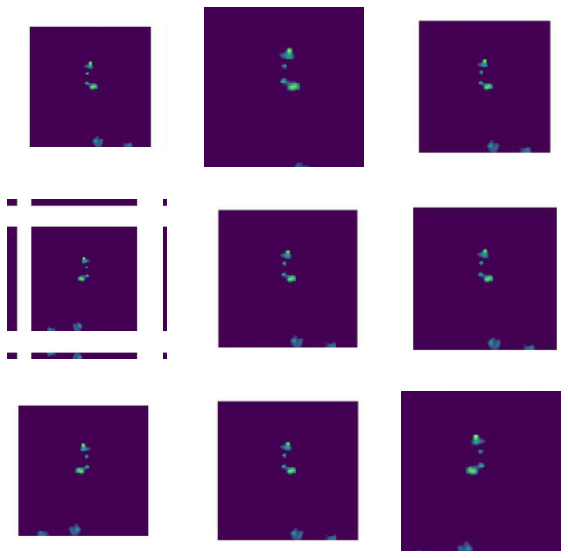

In [8]:
#Applying data augmentation to improve predictions 

data_augmentation = keras.Sequential(
[layers.experimental.preprocessing.RandomFlip("horizontal",
                                             input_shape = (img_height, 
                                                           img_width,
                                                           3)),
#layers.experimental.preprocessing.RandomRotation(0.4),
layers.experimental.preprocessing.RandomZoom(0.3)])

#visualise augmented pics
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
#Applying dropout to improve regularisation, and creating the model 

num_classes = 4

model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding = 'same', activation = 'softplus'), #first layer has 16 filters
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = 'same', activation = 'softplus'), #second layer has 32 filters
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation = 'softplus'), #third layer has 64 filters
    layers.MaxPooling2D(),
    layers.Dropout(0.2), # drop out 20% output units
    layers.Flatten(),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(num_classes)    
])

#compiling and training the model

model.compile(optimizer = 'adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [10]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=vals_ds,
    epochs=epochs)

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 1.2924 - accuracy: 0.3958 - val_loss: 63.5279 - val_accuracy: 0.4167
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 52.0859 - accuracy: 0.5208 - val_loss: 16.5078 - val_accuracy: 0.5833
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 20.5170 - accuracy: 0.4792 - val_loss: 6.9359 - val_accuracy: 0.5833
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 8.6263 - accuracy: 0.4792 - val_loss: 26.2098 - val_accuracy: 0.4167
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 21.4514 - accuracy: 0.5208 - val_loss: 28.3408 - val_accuracy: 0.4167
Epoch 6/20
1/1 [==============================] - 1s 1s/step - loss: 23.3520 - accuracy: 0.5208 - val_loss: 15.0802 - val_accuracy: 0.4167
Epoch 7/20
1/1 [==============================] - 1s 1s/step - loss: 12.4092 - accuracy: 0.5208 - val_loss: 2.0633 - val_accuracy: 0.5833
Epoch 8/20
1/1 [===============

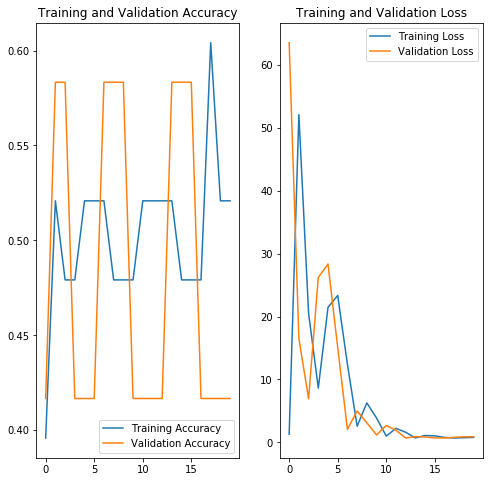

In [11]:
#visualise the results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [12]:
import os
#where the segmented images are:
path = Path(r"C:\Users\neham\Downloads\Year 4\ProjectCodingFiles\Sem1_GAN\kerasGAN\Multi-Class_Classification\TestSet")
path_list = file_list=os.listdir(path)

lines = []

for img in path_list:
    #same path as above
    path = Path(r"C:\Users\neham\Downloads\Year 4\ProjectCodingFiles\Sem1_GAN\kerasGAN\Multi-Class_Classification\TestSet\{}".format(img))
    #print(path)
    img = keras.preprocessing.image.load_img(
    path, target_size = (img_height, img_width))

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) 

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(path, "Class: {} ------  Probability {:.2f} % "
          .format(class_names[np.argmax(score)], 100 * np.max(score)))
    #print(path)
    
    path.__str__()  # convert path to datatype string
    
    path = str(path)
    
    
      
    x = ("---------Class: {} ------  Probability {:.2f} % "
          .format(class_names[np.argmax(score)], 100 * np.max(score)))
    print(type(x))
    print(type(path))
    
    a = str(path + x)
    
    #lines.append(path + x)
    #lines.append(';')
    lines.append(a)

print(lines)
#REMEMBER TO CHANGE THE NAME OF THE TEXT FILE!!!!!!!#
with open((r"C:\Users\neham\Downloads\Year 4\ProjectCodingFiles\Sem1_GAN\kerasGAN\Multi-Class_Classification\MCC_run1.txt"), 'w') as f:
    for i in lines:
        f.write(i)
        f.write('\n')

C:\Users\neham\Downloads\Year 4\ProjectCodingFiles\Sem1_GAN\kerasGAN\Multi-Class_Classification\TestSet\2Beans.jpg Class: DoubleLobedStuff ------  Probability 72.90 % 
<class 'str'>
<class 'str'>
C:\Users\neham\Downloads\Year 4\ProjectCodingFiles\Sem1_GAN\kerasGAN\Multi-Class_Classification\TestSet\2Boomerang.jpg Class: DoubleLobedStuff ------  Probability 72.93 % 
<class 'str'>
<class 'str'>
C:\Users\neham\Downloads\Year 4\ProjectCodingFiles\Sem1_GAN\kerasGAN\Multi-Class_Classification\TestSet\Bean.jpg Class: DoubleLobedStuff ------  Probability 72.95 % 
<class 'str'>
<class 'str'>
C:\Users\neham\Downloads\Year 4\ProjectCodingFiles\Sem1_GAN\kerasGAN\Multi-Class_Classification\TestSet\Boomerang.jpg Class: DoubleLobedStuff ------  Probability 72.92 % 
<class 'str'>
<class 'str'>
C:\Users\neham\Downloads\Year 4\ProjectCodingFiles\Sem1_GAN\kerasGAN\Multi-Class_Classification\TestSet\DoubleLobe1.jpg Class: DoubleLobedStuff ------  Probability 72.94 % 
<class 'str'>
<class 'str'>
C:\Users\n